This notebook's objective is to generate almost same style/structure multi images by pretrained stable diffusion model except for the word part replaced in the prompt (e.g. a black cat -> a white cat), as introduced in the following paper prompt-to-prompt.

https://prompt-to-prompt.github.io/ptp_files/Prompt-to-Prompt_preprint.pdf

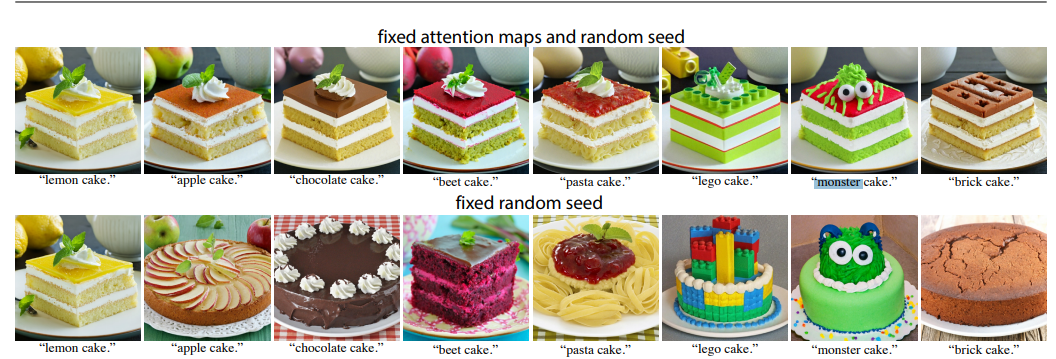

In the paper, attention maps are swapped, but here in this notebook, query/key/value in attention are stored during generation timesteps in cache mode, then in mixing mode, whole query and the part of key correponding to replace word positions are replaced by cached query/key.

In [ ]:
!pip install -U diffusers

In [ ]:
import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import torch
import torch.nn.functional as F
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection
from diffusers import AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.schedulers import KarrasDiffusionSchedulers, DDPMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.image_processor  import VaeImageProcessor
from diffusers.models.attention_processor import AttnProcessor2_0
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_id = "CompVis/stable-diffusion-v1-4"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28

In [ ]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py#L3227
class CustomAttentionProcessor(AttnProcessor2_0):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._mode = None  # None / 'store_cache' / 'fuse_cache'
        self._q_cache_list = []
        self._k_cache_list = []
        self._v_cache_list = []
        self._timestep_index = 0
        self._mixing_pos_mask = None
        self._mix_ratio = 0.5

    def __call__(
        self,
        attn,#: Attention,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        temb: Optional[torch.Tensor] = None,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            print("scale", "1.0.0", deprecation_message)

        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        # print(sequence_length, encoder_hidden_states is None)

        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)  # (bs, n_heads, q_seq_len, head_dim)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)  # (bs, n_heads, k_seq_len, head_dim)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)  # (bs, n_heads, v_seq_len, head_dim)

        if attn.norm_q is not None:
            query = attn.norm_q(query)
        if attn.norm_k is not None:
            key = attn.norm_k(key)

        ############# FOLLOWING ADDED ################
        if self._mode == 'store_cache':
            self._q_cache_list.append(query)
            self._k_cache_list.append(key)
            self._v_cache_list.append(value)
        elif self._mode == 'fuse_cache':
            if self._timestep_index == 0:
                print('mixing start')
            assert not (self._mixing_pos_mask is None)
            assert self._mixing_pos_mask.ndim == 2  # (bs, k_seq_len)
            q_cache = self._q_cache_list[self._timestep_index]
            k_cache = self._k_cache_list[self._timestep_index]
            v_cache = self._v_cache_list[self._timestep_index]

            k_seq_len = k_cache.shape[-2]
            assert k_seq_len == self._mixing_pos_mask.shape[-1]
            # assert k_cache.shape[0] == self._mixing_pos_mask.shape[0]
            # if k_cache.shape[0] != self._mixing_pos_mask.shape[0]:
            #     print(k_cache.shape, self._mixing_pos_mask.shape)

            mixing_pos_mask = self._mixing_pos_mask.unsqueeze(-1).unsqueeze(1).to(key.device)  # (bs, 1, k_seq_len, 1)

            # query = (1.0 - self._mix_ratio) * query + self._mix_ratio * q_cache
            query = q_cache
            # query = 0.5*q_cache + 0.5*query
            key = (
                k_cache * (1.0 - mixing_pos_mask.int()) + key * mixing_pos_mask.int()
            ).to(key.dtype)
            # value = (
            #     v_cache * (1.0 - mixing_pos_mask.int()) + value * mixing_pos_mask.int()
            # ).to(value.dtype)

            self._timestep_index += 1
        ##############################################

        # the output of sdp = (batch, num_heads, seq_len, head_dim)
        # TODO: add support for attn.scale when we move to Torch 2.1
        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

    ############# FOLLOWING ADDED ################
    def reset_and_enable_cache(self):
        self._q_cache_list = []
        self._k_cache_list = []
        self._v_cache_list = []
        self._timestep_index = 0
        self._mode = 'store_cache'

    def enable_mixing(self):
        self._mode = 'fuse_cache'

    def disable_mixing(self):
        self._mode = None

    def reset_timestep_index(self):
        self._timestep_index = 0

    def set_mixing_pos_mask(self, mixing_pos_mask):
        self._mixing_pos_mask = mixing_pos_mask
    ###############################################

In [ ]:
def reset_and_enable_cache(unet):
    for name, m in unet.named_modules():
        if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
            m.processor.reset_and_enable_cache()

def enable_mixing(unet):
    for name, m in unet.named_modules():
        if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
            m.processor.enable_mixing()

def disable_mixing(unet):
    for name, m in unet.named_modules():
        if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
            m.processor.disable_mixing()

def reset_timestep_index(unet):
    for name, m in unet.named_modules():
        if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
            m.processor.reset_timestep_index()

def set_mixing_pos_mask(unet, mixing_pos_mask):
    for name, m in unet.named_modules():
        if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
            m.processor.set_mixing_pos_mask(mixing_pos_mask)

In [ ]:
for name, m in pipe.unet.named_modules():
    if hasattr(m, 'processor') and isinstance(m.processor, AttnProcessor2_0) and name.endswith('attn2'):
        m.processor = CustomAttentionProcessor()
        print(f'replaced {name}')

replaced down_blocks.0.attentions.0.transformer_blocks.0.attn2
replaced down_blocks.0.attentions.1.transformer_blocks.0.attn2
replaced down_blocks.1.attentions.0.transformer_blocks.0.attn2
replaced down_blocks.1.attentions.1.transformer_blocks.0.attn2
replaced down_blocks.2.attentions.0.transformer_blocks.0.attn2
replaced down_blocks.2.attentions.1.transformer_blocks.0.attn2
replaced up_blocks.1.attentions.0.transformer_blocks.0.attn2
replaced up_blocks.1.attentions.1.transformer_blocks.0.attn2
replaced up_blocks.1.attentions.2.transformer_blocks.0.attn2
replaced up_blocks.2.attentions.0.transformer_blocks.0.attn2
replaced up_blocks.2.attentions.1.transformer_blocks.0.attn2
replaced up_blocks.2.attentions.2.transformer_blocks.0.attn2
replaced up_blocks.3.attentions.0.transformer_blocks.0.attn2
replaced up_blocks.3.attentions.1.transformer_blocks.0.attn2
replaced up_blocks.3.attentions.2.transformer_blocks.0.attn2
replaced mid_block.attentions.0.transformer_blocks.0.attn2


In [ ]:
pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2.processor

In [ ]:
def get_input_ids(prompt, pipe=pipe):
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    return text_inputs['input_ids']

In [ ]:
base_prompt_fmt = 'a {replace_word} cake and a tea cup on the desk'

In [ ]:
random_seed = 0

In [ ]:
replace_word = 'lemon'
prompt = base_prompt_fmt.format(replace_word=replace_word)
replace_target_token_id = pipe.tokenizer(replace_word)['input_ids'][1]
print(pipe.tokenizer.decode([replace_target_token_id]))

lemon


In [ ]:
input_ids = get_input_ids(prompt)

In [ ]:
mixing_pos_mask = input_ids == replace_target_token_id

In [ ]:
mixing_pos_mask

tensor([[False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]])

In [ ]:
set_mixing_pos_mask(pipe.unet, mixing_pos_mask)

In [ ]:
pipe.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2.processor._mixing_pos_mask

tensor([[False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]])

In [ ]:
reset_and_enable_cache(pipe.unet)

In [ ]:
image = pipe(
    prompt,
    generator=torch.Generator(device=device).manual_seed(random_seed)#None
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

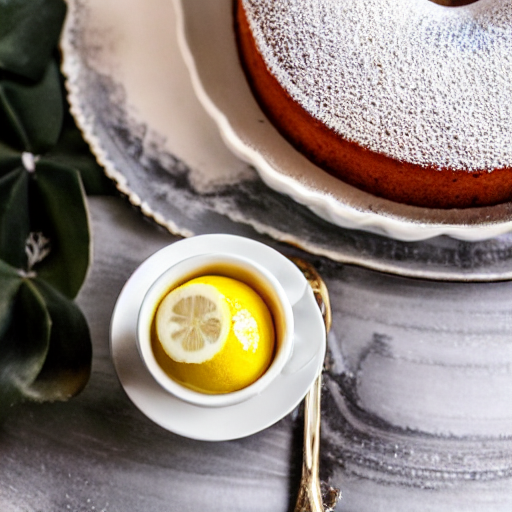

In [ ]:
image

In [ ]:
enable_mixing(pipe.unet)
reset_timestep_index(pipe.unet)

In [ ]:
replace_word = 'grape'
prompt = base_prompt_fmt.format(replace_word=replace_word)
prompt

'a grape cake and a tea cup on the desk'

In [ ]:
image_with_mixing = pipe(
    prompt,
    generator=torch.Generator(device=device).manual_seed(random_seed)#None
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start


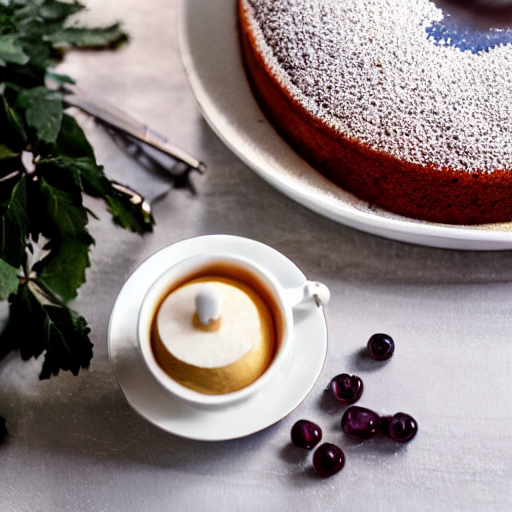

In [ ]:
image_with_mixing

In [ ]:
enable_mixing(pipe.unet)
reset_timestep_index(pipe.unet)

In [ ]:
replace_word = 'grape'
prompt = base_prompt_fmt.format(replace_word=replace_word)
prompt

'a grape cake and a tea cup on the desk'

In [ ]:
image_with_mixing_and_different_seed = pipe(
    prompt,
    generator=torch.Generator(device=device).manual_seed(random_seed+1)#None
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start
mixing start


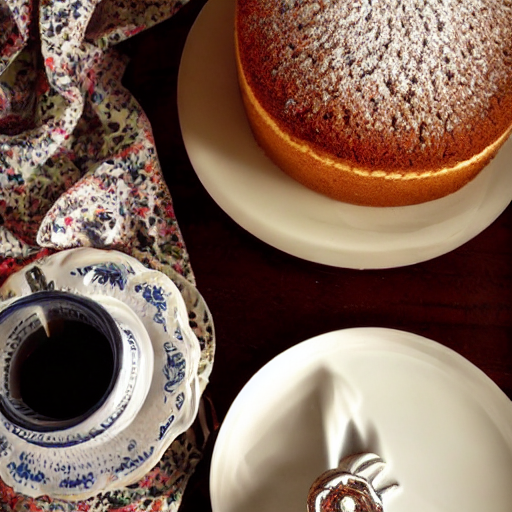

In [ ]:
image_with_mixing_and_different_seed

In [ ]:
disable_mixing(pipe.unet)

In [ ]:
replace_word = 'grape'
prompt = base_prompt_fmt.format(replace_word=replace_word)
prompt

'a grape cake and a tea cup on the desk'

In [ ]:
image_no_mixing = pipe(
    prompt,
    generator=torch.Generator(device=device).manual_seed(0)#None
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

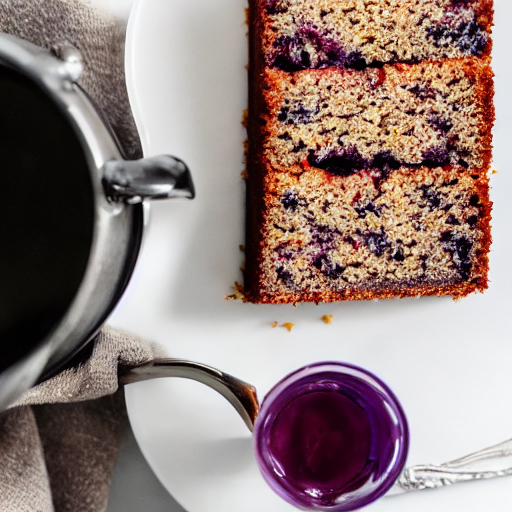

In [ ]:
image_no_mixing

Text(0.5, 1.0, 'mixing on | a grape cake and a tea cup on the desk | seed 1')

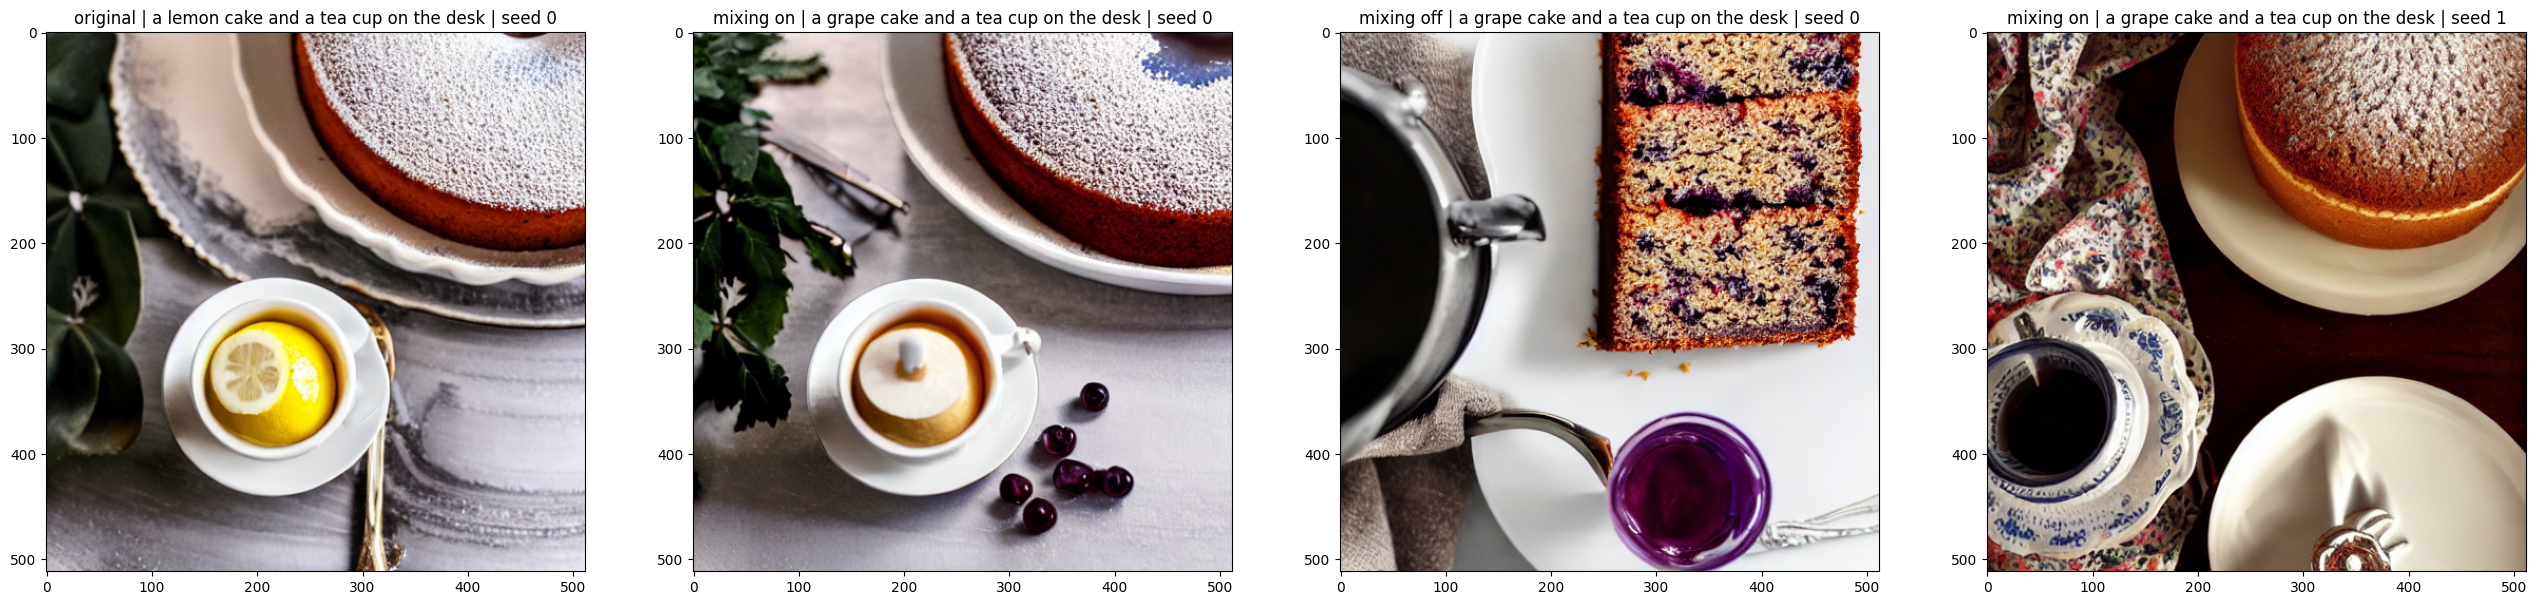

In [ ]:
fix, axes = plt.subplots(ncols=4, nrows=1, figsize=(8*4, 8))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title(f'original | a lemon cake and a tea cup on the desk | seed {random_seed}')
axes[1].imshow(image_with_mixing)
axes[1].set_title(f'mixing on | a grape cake and a tea cup on the desk | seed {random_seed}')
axes[2].imshow(image_no_mixing)
axes[2].set_title(f'mixing off | a grape cake and a tea cup on the desk | seed {random_seed}')
axes[3].imshow(image_with_mixing_and_different_seed)
axes[3].set_title(f'mixing on | a grape cake and a tea cup on the desk | seed {random_seed+1}')

when mixing is off (third figure), structure is different compared to the base original image (first figure) and that of when mixing is on (second figure).